In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_34729/4123414874.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-22 23:04:11.202851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
USD = Asset.make_USD()
BTC = Asset('BTC')
#BTC.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
ETH = Asset('ETH')
#ETH.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
USDT = Asset('USDT')
#USDT.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-01-01'), date_to = tmpstemp('2024-03-31'))

In [6]:
class Strategy:

    def __init__(self):
        self.frequency = 1
        self.model = Model()
        self.input_span = 15

    def suggest_decision(self, portfolio: Portfolio):
        '''
        Returns a datframe with the suggested updates to portfolio
        '''
        delta_df = pd.DataFrame()
        return delta_df

    def backtest(self, hist_data: pd.DataFrame, portfolio: Portfolio):
        updated_portfolio = Portfolio()
        return updated_portfolio
    
    def train_val_split_scale(self, df, scaler, input_span):
        len_train = int(0.7*len(df))
        X = []
        y = []
        scaled_data = scaler.fit_transform(np.array(df['close'].values).reshape(-1,1) )
        for x in range(input_span, len(df)):
            X.append(scaled_data[x-input_span:x, 0])
            y.append(scaled_data[x,0])
        X, y = (np.array(X), np.array(y))
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        train_idx = df.index[input_span:len_train]
        val_index = df.index[len_train:]
        print(f'from {train_idx[0]} to {train_idx[-1]}')
        return X[0:len_train-input_span,:,:], y[0:len_train-input_span], train_idx, X[len_train-input_span:,:,:], y[len_train-input_span:], val_index



In [7]:
naive_LSTM = Strategy()

2024-04-21 21:42:01.581754: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
input_span = 15
scaler  = MinMaxScaler(feature_range=(0,1))
x_train, y_train, train_idx, x_val, y_val, val_idx = naive_LSTM.train_val_split_scale(BTC.history, scaler, input_span)

from 2022-01-15 19:00:00 to 2023-05-03 20:00:00


In [9]:
hidden_size = 50
dropout = 0.2
learning_rate = 0.001

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = 'input')

LSTM1 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM1' )(input_layer)
LSTM1 = Dropout(dropout)(LSTM1)

LSTM2 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM2' )(LSTM1)
LSTM2 = Dropout(dropout)(LSTM2)

LSTM3 = LSTM(units = 50, activation='tanh', name = 'LSTM3' )(LSTM2)
LSTM3 = Dropout(dropout)(LSTM3)

hidden1 = Dense(hidden_size, activation='relu', name='hidden_layer1')(LSTM3)
hidden1 = Dropout(dropout)(hidden1)


# Create output layer
out = Dense(1, activation='linear', name = 'Regression_layer')(hidden1)
model = Model(inputs=[input_layer], outputs=out)


model.compile(optimizer=Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])
naive_LSTM.model = model
naive_LSTM.model.summary()

2024-04-21 21:42:02.485422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 21:42:02.488830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 21:42:02.491709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 LSTM1 (LSTM)                (None, 15, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 15, 50)            0         
                                                                 
 LSTM2 (LSTM)                (None, 15, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 15, 50)            0         
                                                                 
 LSTM3 (LSTM)                (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0   

2024-04-21 21:42:03.334689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 21:42:03.337989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 21:42:03.340961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [10]:
#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

naive_LSTM.model.fit([x_train], y_train, 
          validation_data=([x_val], y_val),
          epochs=20, batch_size=32,
          callbacks=[early_stopping])


Epoch 1/20


2024-04-21 21:42:04.229639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 21:42:04.233579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 21:42:04.237399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - ETA: 0s - loss: 0.0666 - mean_squared_error: 0.0666

2024-04-21 21:42:27.345433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 21:42:27.349209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 21:42:27.355806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 27s 584ms/step - loss: 0.0666 - mean_squared_error: 0.0666 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 2/20
15/15 [==============================] - 4s 294ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 3/20
15/15 [==============================] - 4s 254ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 4/20
15/15 [==============================] - 3s 187ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/20
15/15 [==============================] - 4s 240ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 6/20
15/15 [==============================] - 3s 215ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 7/20
15/15 [====================

In [11]:
predicted = {}
current = {}

# Given the new data go one time point after another and make predictions 
for x in range(1,len(val_idx)):
    model_input = x_val[x,:,:].reshape(1,input_span,1)                       # Data shaped as input for the model
    pred_BTC_price = naive_LSTM.model.predict(model_input, verbose=0)                                # Predict
    pred_BTC_price = scaler.inverse_transform(pred_BTC_price)[0][0]                        # Un-scale to get predicted asset price

    # Format string for output
    current_date = val_idx[x-1]
    predicted_for_date = val_idx[x]                   # Get date we are predictig for 
    curr_BTC_price = BTC.history['close'].loc[current_date]                                             # Get current asset price 
    #print(f'Today ({val_idx[x]}):{curr_BTC_price}, predicted for {predicted_for_date}: {pred_BTC_price}')
    predicted[predicted_for_date] = pred_BTC_price
    current[current_date] = curr_BTC_price                                               # Save the result in the output array
predicted_df = pd.DataFrame(columns = ['predicted'], data = predicted.values(), index = pd.DatetimeIndex(predicted.keys(), name = 'date_time'))
current_df = pd.DataFrame(columns = ['current'], data = current.values(), index = pd.DatetimeIndex(current.keys(), name = 'date_time'))
df_to_plot = pd.merge(current_df, predicted_df, left_index=True, right_index=True)
df_to_plot.head()

2024-04-21 21:43:00.284395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-21 21:43:00.287760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-21 21:43:00.291761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

,current,predicted
date_time,,
2023-05-05 20:00:00,28902.66,28827.169922
2023-05-06 20:00:00,28474.53,28978.572266
2023-05-07 20:00:00,27695.06,29080.388672
2023-05-08 20:00:00,27647.29,29181.117188
2023-05-09 20:00:00,27624.01,29262.183594


In [44]:
first_day = df_to_plot.index[0]-tmpdelta(days=1)
BTC_price = BTC.history['close'].loc[first_day]
my_portfolio = Portfolio(first_day, initial_deposit=BTC_price * 0.5)
my_portfolio.update_transactions(ticker='BTC', qty=0.5, transaction_date=first_day)
my_portfolio.transactions

change             note
date_time           ticker                           
2023-05-04 20:00:00 USD     14768.38  Initial deposit
                    BTC          0.5

In [53]:
def make_suggestion(today, tomorrow, portfolio):
    risk_rate = 0.05
    fee_rate = 0.006
    
    positions = portfolio.get_positions(today)
    suggestions = pd.DataFrame(columns = ['change_in_size', 'USD_value', 'note'], index = positions.index)

    # If BTC is predicted to go up - buy it
    if df_to_plot['predicted'].loc[tomorrow] > df_to_plot['current'].loc[today]:
        USD_to_spend = risk_rate * positions['position_value'].loc['USD']  # In this strategy, we change position by risk_rate% on every step
        ext_price = USD_to_spend/(1 + fee_rate)                    # This is how much will be paid for BTC, extended price
        fees = USD_to_spend - ext_price                            # This is plaform fees
        BTC_price = BTC.history['close'].loc[today]                # BTC price at the time of decision
        BTC_to_buy = ext_price/BTC_price
        suggestions.loc['BTC'] = [BTC_to_buy, ext_price, 'Buy BTC']
        suggestions.loc['USD'] = [-USD_to_spend,-USD_to_spend, 'BTC price w fees']

    # If BTC is predicted to go down - sell it
    if df_to_plot['predicted'].loc[tomorrow] < df_to_plot['current'].loc[today]:
        BTC_to_spend = risk_rate * positions['position_size'].loc['BTC']  # In this strategy, we change position by risk_rate% on every step
        ext_price = BTC_to_spend/(1 + fee_rate)                    # This is how much BTC will be sold, extended price
        fees = BTC_to_spend - ext_price                            # This is plaform fees
        BTC_price = BTC.history['close'].loc[today]                # BTC price at the time of decision
        USD_to_buy = ext_price*BTC_price
        suggestions.loc['BTC'] = [-BTC_to_spend, -BTC_to_spend, 'Sell BTC w fees']
        suggestions.loc['USD'] = [USD_to_buy, USD_to_buy, 'BTC sale']
        suggestions.dropna(inplace=True)

    return suggestions

def execute_suggestions(suggestions, portfolio):
    for ticker in suggestions.index:
        portfolio.update_transactions(ticker = str(ticker),
                                    qty =  suggestions['change_in_size'].loc[ticker],
                                    transaction_date = today,
                                    note =  suggestions['note'].loc[ticker])

for x in range (len(df_to_plot)-1):
    today = df_to_plot.index[x]
    tomorrow = df_to_plot.index[x+1]
    suggestion = make_suggestion(today, tomorrow, my_portfolio)
    execute_suggestions(suggestion, my_portfolio)

my_portfolio.update_value(up_to=df_to_plot.index[-1])

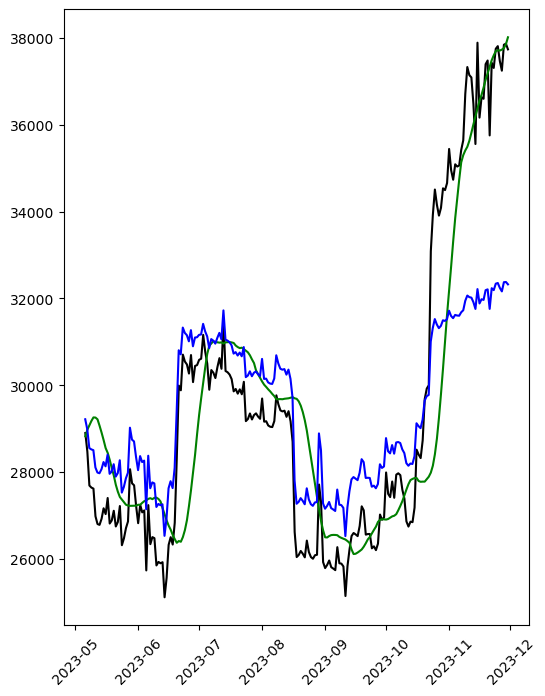

In [54]:
# Plot the results
fig, ax = plt.subplots(1, 1, sharex = True)
fig.set_figheight(8)
fig.set_figwidth(6)
ax.plot(df_to_plot.index, df_to_plot['current'], color = 'black', label = 'Actual')
ax.plot(df_to_plot.index, df_to_plot['predicted'], color = 'green', label = 'Predicted')
ax.plot(my_portfolio.value.index, my_portfolio.value['value'], color = 'blue', label = 'Portfolio')
for tick in ax.get_xticklabels():
        tick.set_rotation(45)